# Actividad 2: Análisis sintáctico
**Universidad Internacional de La Rioja (UNIR) - Máster Universitario en Inteligencia Artificial - Procesamiento del Lenguaje Natural**

***
**Datos de los alumnos (Nombres y Apellidos):**
    
&emsp;- César David Sáenz Salazar
    
&emsp;- Alvaro Pinto Mamani

*Fecha: 24/01/2023*
***

## Índice
* [1) Definición de funciones](#1)
* [2) Inicialización del las reglas sintácticas](#2)
* [3) Aplicación del algoritmo CKY](#3)

### 1. Definición de funciones<a class="anchor" id="1"></a>

In [634]:
from graphviz import Graph, Digraph, nohtml
from IPython.display import Image, display


In [635]:
class MatrixRule:
    def __init__(self, symbol, rule, origin, probability):
        self.symbol = symbol
        self.rule = rule
        self.origin = origin
        self.probability = probability

    def get_symbol(self):
        return self.symbol

    def get_rule(self):
        return self.rule

    def get_origin(self):
        return self.origin

    def get_probability(self):
        return self.probability

    def get_data(self):
        return self.symbol + ": " + str(self.rule) + " <- " + str(self.origin) + " | " + str(self.probability)


def algorithm_CKY(phrase, grammar):
    # Definición de la matriz para el algoritmo CKY
    len_words = len(phrase)
    matrix = [[[] for _ in range(len_words)] for _ in range(len_words)]

    # Análisis de la primer diagonal
    for n in range(len_words):
        for key, rules in grammar.items():
            for rule in rules:
                rule_elements = rule[1]
                if phrase[n] in rule_elements:
                    matrix[n][n].append(
                        MatrixRule(symbol=key, rule=rule_elements, origin="-", probability=rule[0])
                    )

    # Análisis del resto de la matriz
    for n in range(1, len_words):
        for i in range(len_words - n):
            j = i + n
            for k in range(i, j):
                for key, rules in grammar.items():
                    for rule in rules:
                        rule_elements = rule[1]
                        for matrix_rule_1 in matrix[i][k]:
                            for matrix_rule_2 in matrix[k+1][j]:
                                symbol = matrix_rule_1.get_symbol() + " " + matrix_rule_2.get_symbol()
                                if symbol in rule_elements:
                                    origin = ((i, k), (k+1, j))
                                    probability = rule[0] * matrix_rule_1.get_probability() * matrix_rule_2.get_probability()
                                    matrix[i][j].append(
                                        MatrixRule(symbol=key, rule=rule_elements, origin=origin, probability=probability)
                                    )
    return len_words, matrix

# matrix: matríz resultado del algoritmo CKY con probabilidades
# x: fila
# y: columna
# tree_list: arreglo con los nodos padres e hijos
# father: parámetro para definir al padre, no se aplica en el primer nodo
# rules: parámetro que define la creación de nodos hijos en la función recursiva
# root: puntero de los nodos hijos

def get_tree(matrix, x, y, tree_list, father = '', rules = '', root = 0):

    tree = []
    max = 0
    # Ciclo para encontrar el origen en la matríz resultado del algoritmo CKY, variante con probabilidades
    for m in matrix[x][y]:
        # Si existen reglas de entrada al nodo se define la posición que alimentará al nodo
        if(rules != ''):
            if isinstance(rules, str):
                rules = rules.split()

            for rule in rules:
                if(rule == m.get_symbol()):
                    max = m.get_probability()
                    if(len(tree) == 0):
                        tree.append(m)
        # Si no existen reglas de entrada se entiende que estamos por definir el primer nodo padre
        else:
            if(m.get_probability() > max):
                max = m.get_probability()
                # Sobreescribimos el primer nodo siempre que sea el primer nodo padre
                if(len(tree) == 0):
                    tree.append(m)
                else:
                    tree[0] = m
    
    if(len(tree) > 0):
        #print('max: {}, en el nivel {}:{}, origen: {}'.format(tree[0].get_probability(), x, y, tree[0].get_origin()))

        check = 0
        child = tree[0].get_symbol()
        # Definimos reglas para evitar nodos duplicados
        for el in tree_list:
            if(el['father'] == father and el['child'] == tree[0].get_symbol()):
                check = 1
            if(father == tree[0].get_symbol()):
                check = 1
            
        position = len(tree_list)
        probability = str(tree[0].get_probability())

        if(check == 0):
            # Insertamos un nodo padre/hijo
            tree_list.append(
                {
                    'x': str(x),
                    'y': str(y),
                    'father': father,
                    'child': child,
                    'root': root,
                    'position': position,
                    'probability': probability,
                }
            )

        # Evaluamos si este tiene dependencia en la matríz, lo que creará nuevos nodos
        z = tree[0].get_origin()
        if(z != '-'):
            for k in z:
                # Mediante una función recursiva a sí misma, get_tree(), obtenemos los nodos del en base a la ruta de Viterbi
                get_tree(matrix, k[0], k[1], tree_list, tree[0].get_symbol(), tree[0].get_rule(), position)

    
    return tree_list

def ploot_tree(tree_list):
    # Instancia de la librería de graficación de nodos graphviz
    g = Digraph('g', filename='btree.gv', node_attr={'shape': 'record', 'height': '.1'})
    
    # Ciclo para definir los nodos sin relaciones y/o punteros
    for i in range(len(tree_list)):
            # Imprimir nodos con probabilidad en una 4ta casilla
            #g.node('node'+str(i), nohtml('<f0> root:'+str(tree_list[i]['root'])+'|<f1> position:'+str(tree_list[i]['position'])+'|<f2>'+tree_list[i]['child'])+'|<f3> ('+tree_list[i]['x']+', '+tree_list[i]['y']+')'+'|<f4> prob. '+tree_list[i]['probability'])

            # Imprimir nodos sin la casilla de probabilidad
            g.node('node'+str(i), nohtml('<f0> root:'+str(tree_list[i]['root'])+'|<f1> position:'+str(tree_list[i]['position'])+'|<f2>'+tree_list[i]['child'])+'|<f3> ('+tree_list[i]['x']+', '+tree_list[i]['y']+')')

    # Cliclo para definir los punteros en los nodos padres hacia los nodos hijos
    for i in range(len(tree_list)):
        if(tree_list[i]['father'] != ''):
            g.edge('node'+str(tree_list[i]['root'])+':f0', 'node'+str(tree_list[i]['position'])+':f1')

    # Visualización del ploot
    display(g)


def print_matrix(len_words, matrix):
    # Datos de la matriz
    for n in range(len_words):
        for i in range(len_words):
            print(n, i)
            tree_list = []
            for matrix_rule in matrix[n][i]:
                print(matrix_rule.get_data())
            # Obtención del árbol con la ruta de Viterbi según el algoritmo CKY
            tree = get_tree(matrix, n, i, tree_list)
            #print(tree)
            # Si el árbol tiene al menos un elemento, se grafica
            if(len(tree) > 0):
                ploot_tree(tree)

### 2. Inicialización del las reglas sintácticas<a class="anchor" id="2"></a>

In [636]:
# Definición de la frase a análizar
phrase = "time flies like an arrow"
phrase = phrase.split()

# Definición de las reglas gramaticales
grammar = {
    "S": ((0.8, ('NP VP')),),
    "NP": ((0.002, ('time', 'flies', 'arrow')),
           (0.3, ('Det Nom')),
           (0.2, ('Nom Nom'))
           ),
    "Nom": ((0.002, ('time', 'flies', 'arrow')),
                (0.1, ('Nom Noun')),
                (0.2, ('Nom PP'))
                ),
    "VP": ((0.004, ('time')),
           (0.008, ('flies', 'like')),
           (0.3, ('Verb NP')),
           (0.2, ('Verb PP'))
           ),
    "PP": ((0.1, ('Prep NP')),),
    "Verb": ((0.01, ('time')),
             (0.02, ('flies', 'like'))
             ),
    "Noun": ((0.01, ('time', 'flies', 'arrow')),),
    "Det": ((0.05, ('an')),),
    "Prep": ((0.05, ('like')),),
}

### 3. Aplicación del algoritmo CKY<a class="anchor" id="3"></a>

0 0
NP: ('time', 'flies', 'arrow') <- - | 0.002
Nom: ('time', 'flies', 'arrow') <- - | 0.002
VP: time <- - | 0.004
Verb: time <- - | 0.01
Noun: ('time', 'flies', 'arrow') <- - | 0.01


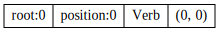

0 1
S: NP VP <- ((0, 0), (1, 1)) | 1.2800000000000001e-05
NP: Nom Nom <- ((0, 0), (1, 1)) | 8.000000000000001e-07
Nom: Nom Noun <- ((0, 0), (1, 1)) | 2.0000000000000003e-06
VP: Verb NP <- ((0, 0), (1, 1)) | 6e-06


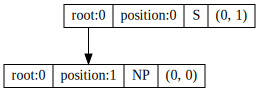

0 2
S: NP VP <- ((0, 1), (2, 2)) | 5.120000000000001e-09


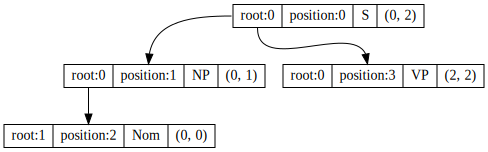

0 3
0 4
S: NP VP <- ((0, 0), (1, 4)) | 9.600000000000004e-13
NP: Nom Nom <- ((0, 0), (1, 4)) | 2.400000000000001e-14
S: NP VP <- ((0, 1), (2, 4)) | 1.1520000000000003e-13
Nom: Nom PP <- ((0, 1), (2, 4)) | 6.000000000000003e-14


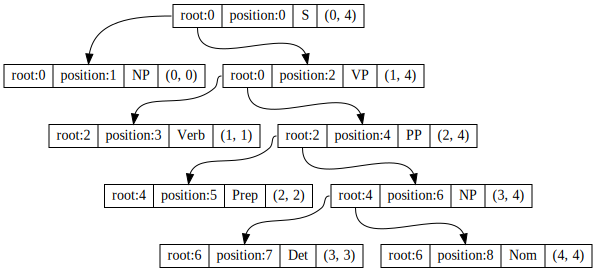

1 0
1 1
NP: ('time', 'flies', 'arrow') <- - | 0.002
Nom: ('time', 'flies', 'arrow') <- - | 0.002
VP: ('flies', 'like') <- - | 0.008
Verb: ('flies', 'like') <- - | 0.02
Noun: ('time', 'flies', 'arrow') <- - | 0.01


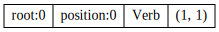

1 2
S: NP VP <- ((1, 1), (2, 2)) | 1.2800000000000001e-05


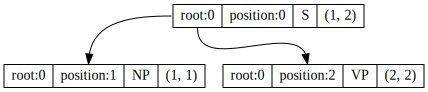

1 3
1 4
S: NP VP <- ((1, 1), (2, 4)) | 2.88e-10
Nom: Nom PP <- ((1, 1), (2, 4)) | 6.000000000000003e-11
VP: Verb PP <- ((1, 1), (2, 4)) | 6.000000000000002e-10


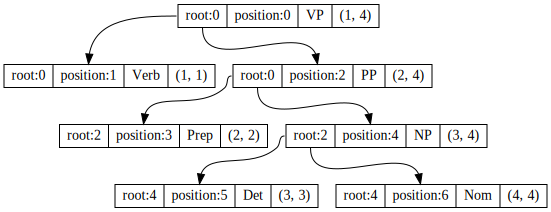

2 0
2 1
2 2
VP: ('flies', 'like') <- - | 0.008
Verb: ('flies', 'like') <- - | 0.02
Prep: like <- - | 0.05


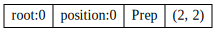

2 3
2 4
VP: Verb NP <- ((2, 2), (3, 4)) | 1.8e-07
PP: Prep NP <- ((2, 2), (3, 4)) | 1.5000000000000005e-07


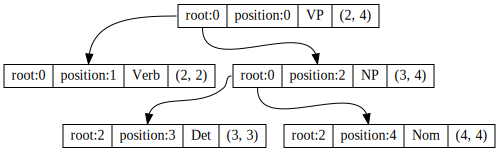

3 0
3 1
3 2
3 3
Det: an <- - | 0.05


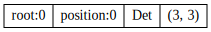

3 4
NP: Det Nom <- ((3, 3), (4, 4)) | 3e-05


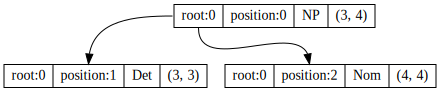

4 0
4 1
4 2
4 3
4 4
NP: ('time', 'flies', 'arrow') <- - | 0.002
Nom: ('time', 'flies', 'arrow') <- - | 0.002
Noun: ('time', 'flies', 'arrow') <- - | 0.01


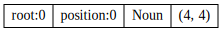

In [637]:
len_words, matrix = algorithm_CKY(phrase, grammar)
print_matrix(len_words, matrix)